In [16]:
data_file_path = 'C:\data\CM003_10min.gzip'

import gzip
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import get_dataframe,APPS, APPS_DICT

with gzip.open(data_file_path, 'rb') as data_file:
    data = pickle.load(data_file)

df = pd.DataFrame(data)

In [17]:
df.describe()

,20,9,5,34,35,42,47,48,28,hour_cos,day_cos,month_cos,hour_sin,day_sin,month_sin
count,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,1.169280e+05,1.169280e+05,1.169280e+05
mean,8.948387,10.807898,2.218423,9.459993,13.359340,0.820728,13.522405,13.654070,1.418768,0.041667,0.142857,-0.007047,-4.934157e-17,-2.815364e-17,-4.723989e-02
std,54.537491,67.740096,37.901401,12.648020,123.645112,15.721875,123.286093,123.930300,14.868140,0.720487,0.742311,0.743846,6.922216e-01,6.546565e-01,6.666483e-01
min,2.037653,0.102080,0.000000,8.596221,1.373499,0.000000,1.505871,1.596783,0.155587,-0.990686,-1.000000,-0.959493,-9.976688e-01,-8.660254e-01,-9.898214e-01
25%,4.025425,0.102080,0.000000,8.601741,1.388306,0.000000,1.543996,1.602915,0.226363,-0.626438,-0.500000,-0.654861,-6.560249e-01,-8.660254e-01,-7.557496e-01
50%,4.025425,0.102080,0.000000,8.601741,1.388306,0.000000,1.543996,1.602915,0.226363,0.067607,0.500000,-0.142315,-1.224647e-16,0.000000e+00,-1.133108e-15
75%,4.025425,0.102080,0.000000,8.601741,1.388306,0.000000,1.543996,1.602915,0.226363,0.725520,1.000000,0.841254,6.560249e-01,8.660254e-01,5.406408e-01
max,1700.976563,1228.367092,1608.115292,1232.505274,3703.718791,1778.863614,3659.675487,3704.514267,531.300757,1.000000,1.000000,1.000000,9.976688e-01,8.660254e-01,9.898214e-01


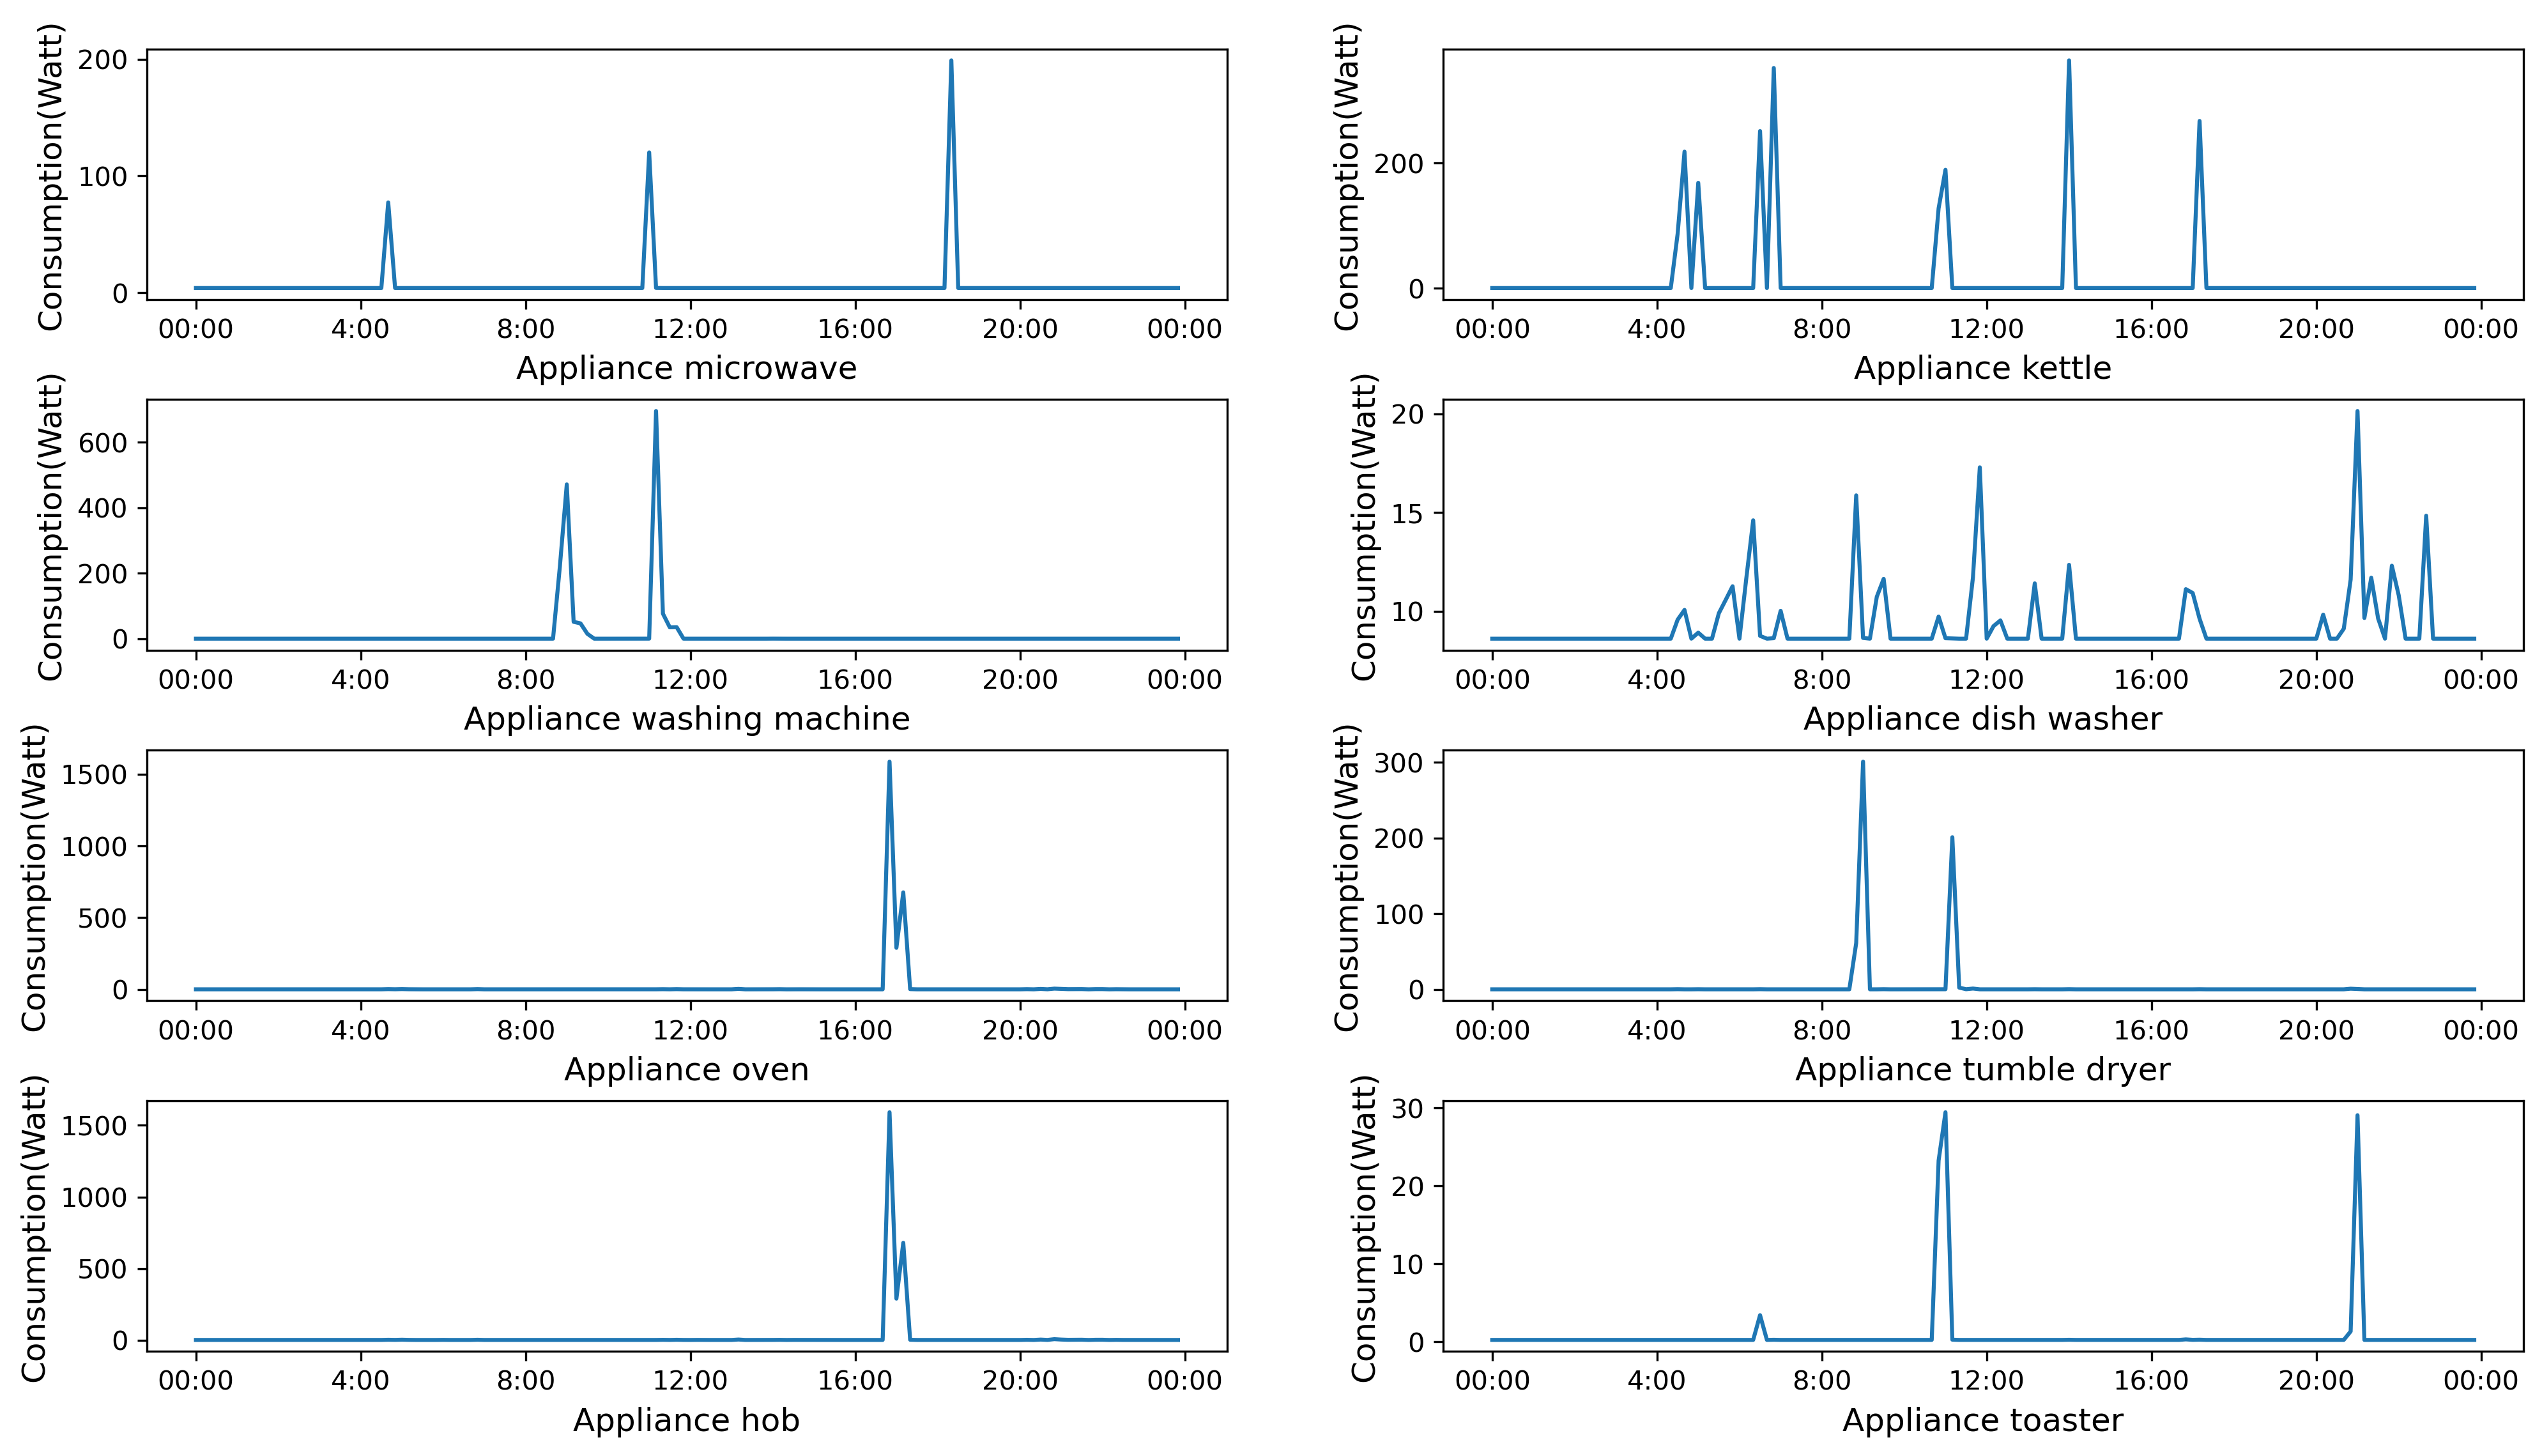

In [18]:
plt.figure(figsize=(16,9), dpi=300)
grid = plt.GridSpec(nrows=4, ncols=2, wspace=0.2, hspace=0.4)
SLOT = 24

for i, app in enumerate(APPS):
    fig = plt.subplot(grid[int(i/2), int(i%2)])
    fig.plot(df[app][144*(SLOT):144*(SLOT+1)])
    fig.set_xticks(np.array([0,24,48,72,96,120,144]) +144*(SLOT))
    fig.set_xticklabels(['00:00', '4:00', '8:00', '12:00','16:00', '20:00', '00:00'])
    fig.set_xlabel('Appliance ' + APPS_DICT[app])
    fig.set_ylabel('Consumption(Watt)')

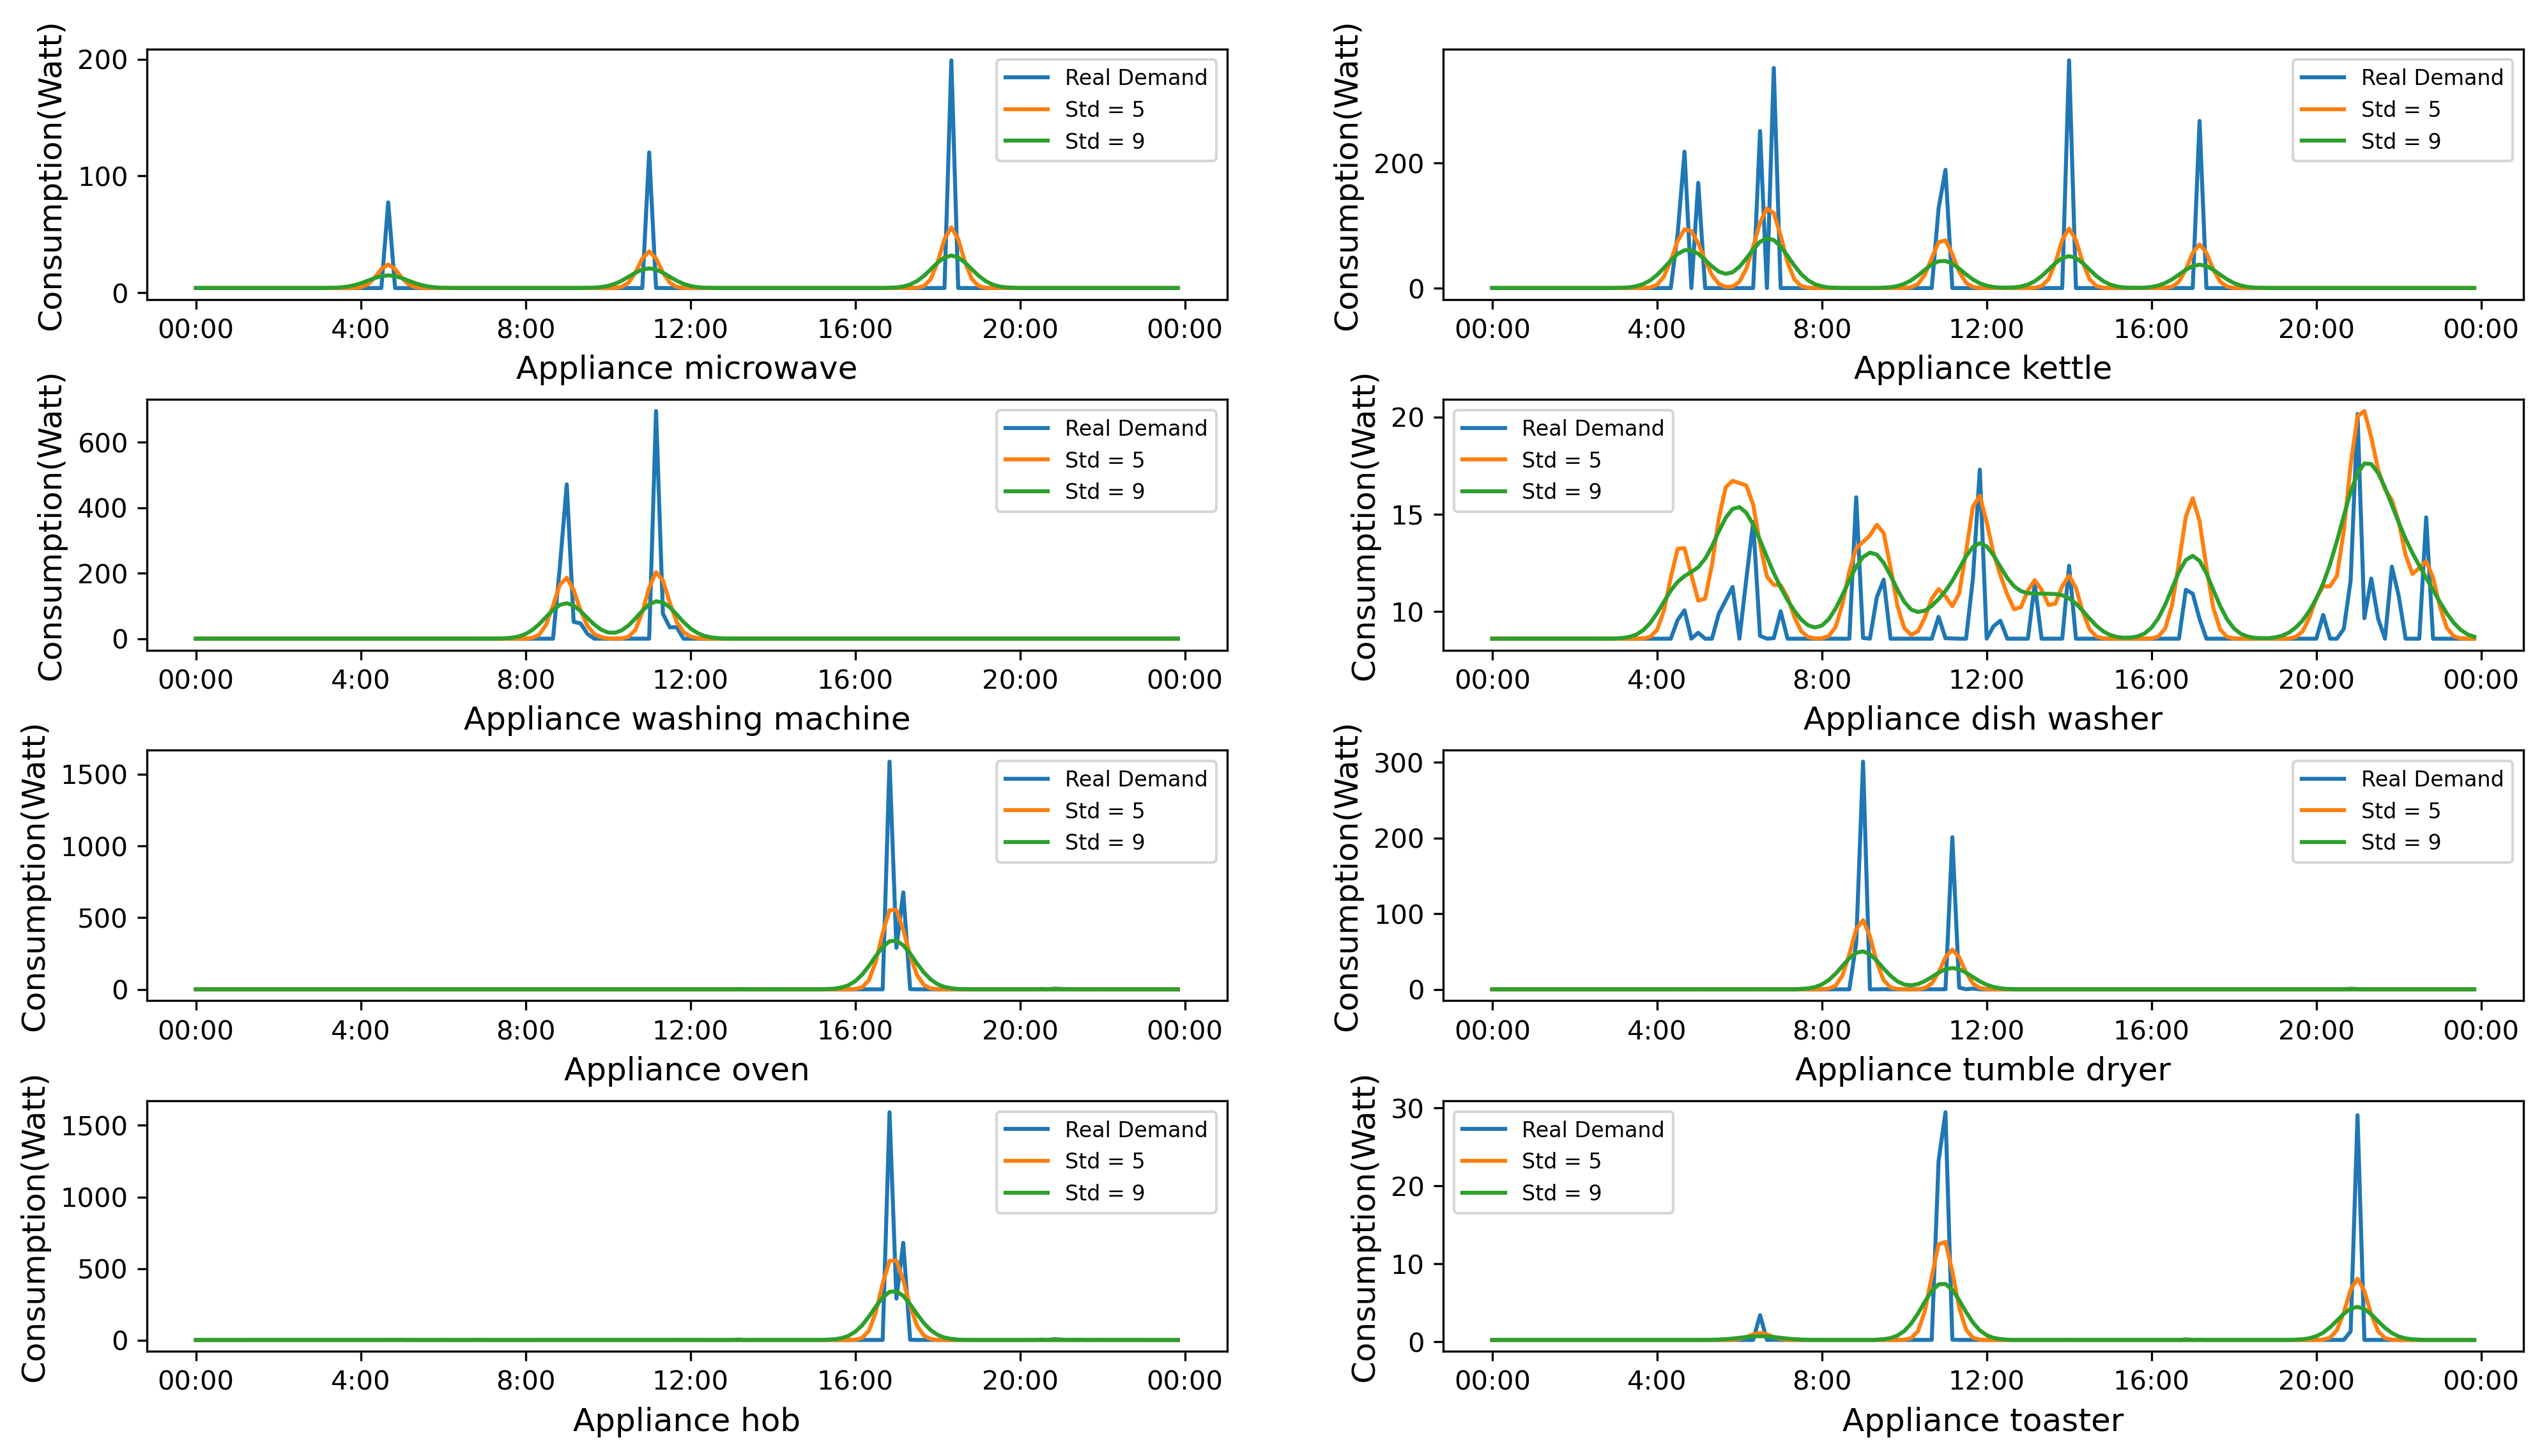

In [19]:
from cProfile import label
from scipy.stats import norm

def _normal_probability(std):
    timestamp = np.linspace(-3, 3, 2*std)
    _norm_h = norm.cdf(timestamp[:std+1])
    _norm = [_norm_h[0]]
    for i in range(1, 2*std+1):
        if i<=std:
            _norm.append(_norm_h[i]-_norm_h[i-1])
        else:
            _norm.append(_norm[2*std-i])
    return np.array(_norm)

def norm_label(label, std):
    # _label = deepcopy(label)
    if std==0:
        return label
    _label = np.zeros_like(label)+label.min()
    _norm = _normal_probability(std)

    indices = np.where(label-label.mean()>0)[0]
    length = _label.shape[0]
    
    for index in indices:
        timestamp = index
        start = 0 if timestamp-std<0 else timestamp-std
        end = length if timestamp+std+1>length else timestamp+std+1
        multiplier = _norm[std-(timestamp-start) : std+(end-timestamp)]
        _label[start:end] += np.multiply(label[index], multiplier)
    return _label

plt.figure(figsize=(16,9), dpi=300)
plt.rc('legend', fontsize=8)
plt.rc('axes', labelsize=12)
grid = plt.GridSpec(nrows=4, ncols=2, wspace=0.2, hspace=0.4)
SLOT = 24
for i, app in enumerate(APPS):
    fig = plt.subplot(grid[int(i/2), int(i%2)])
    fig.plot(norm_label(df[app][144*(SLOT):144*(SLOT+1)].to_numpy(), std=0), label='Real Demand')
    fig.plot(norm_label(df[app][144*(SLOT):144*(SLOT+1)].to_numpy(), std=5), label='Std = 5')
    fig.plot(norm_label(df[app][144*(SLOT):144*(SLOT+1)].to_numpy(), std=9), label='Std = 9')
    fig.set_xticks([0,24,48,72,96,120,144])
    fig.set_xticklabels(['00:00', '4:00', '8:00', '12:00','16:00', '20:00', '00:00'])
    fig.set_xlabel('Appliance ' + APPS_DICT[app])
    fig.set_ylabel('Consumption(Watt)')
    fig.legend()


In [20]:
# def consumption_count(data):
#     th = data.mean()
#     x = []
#     for i, value in enumerate(data):
#         if value >= th:
#             x.append(value)
#     x = np.array(x)
#     x.sort()
#     return x

# plt.figure(figsize=(16,9), dpi=200)
# x = {}
# for j, app in enumerate(APPS):
#     x[app] = consumption_count(df[app])
# plt.xticks(ticks=np.arange(1, len(APPS)+1), labels=APPS_DICT.values(), rotation=45)
# plt.xlabel(APPS)
# plt.violinplot(x.values())
# plt.savefig('./output/kwh.png')

In [21]:
# plt.figure(figsize=(16,9), dpi=200)
# x = {}
# for j, app in enumerate(APPS):
#     static = consumption_count(df[app])
#     fig = plt.subplot(4,2,j+1)
#     # fig.plot(x, df[app][i*144:(i+1)*144])
#     fig.hist(static)
#     fig.set_xlabel('Appliance ' + APPS_DICT[app])
#     fig.set_ylabel('Frequency')

In [22]:
# def frequency_count(data):
#     x = np.zeros((144))
#     th = data.mean()
#     for i in range(int(812)):
#         index = np.where(data[i*144:(i+1)*144]>th)
#         x[index] += 1
#     return x

# plt.figure(figsize=(16,9), dpi=200)
# x = list(range(144))
# for j, app in enumerate(APPS):
#     fig = plt.subplot(4,2,j+1)
#     frequency = frequency_count(df[app])
#     # fig.plot(x, df[app][i*144:(i+1)*144])
#     fig.plot(x, frequency)
#     fig.set_xlabel('Appliance ' + APPS_DICT[app])
#     fig.set_ylabel('Frequency')
# plt.tight_layout()
# plt.savefig('./output/frequency.png')

In [23]:
df_std = get_dataframe(data_file_path, scale=2, shift=-1, normstd=5)

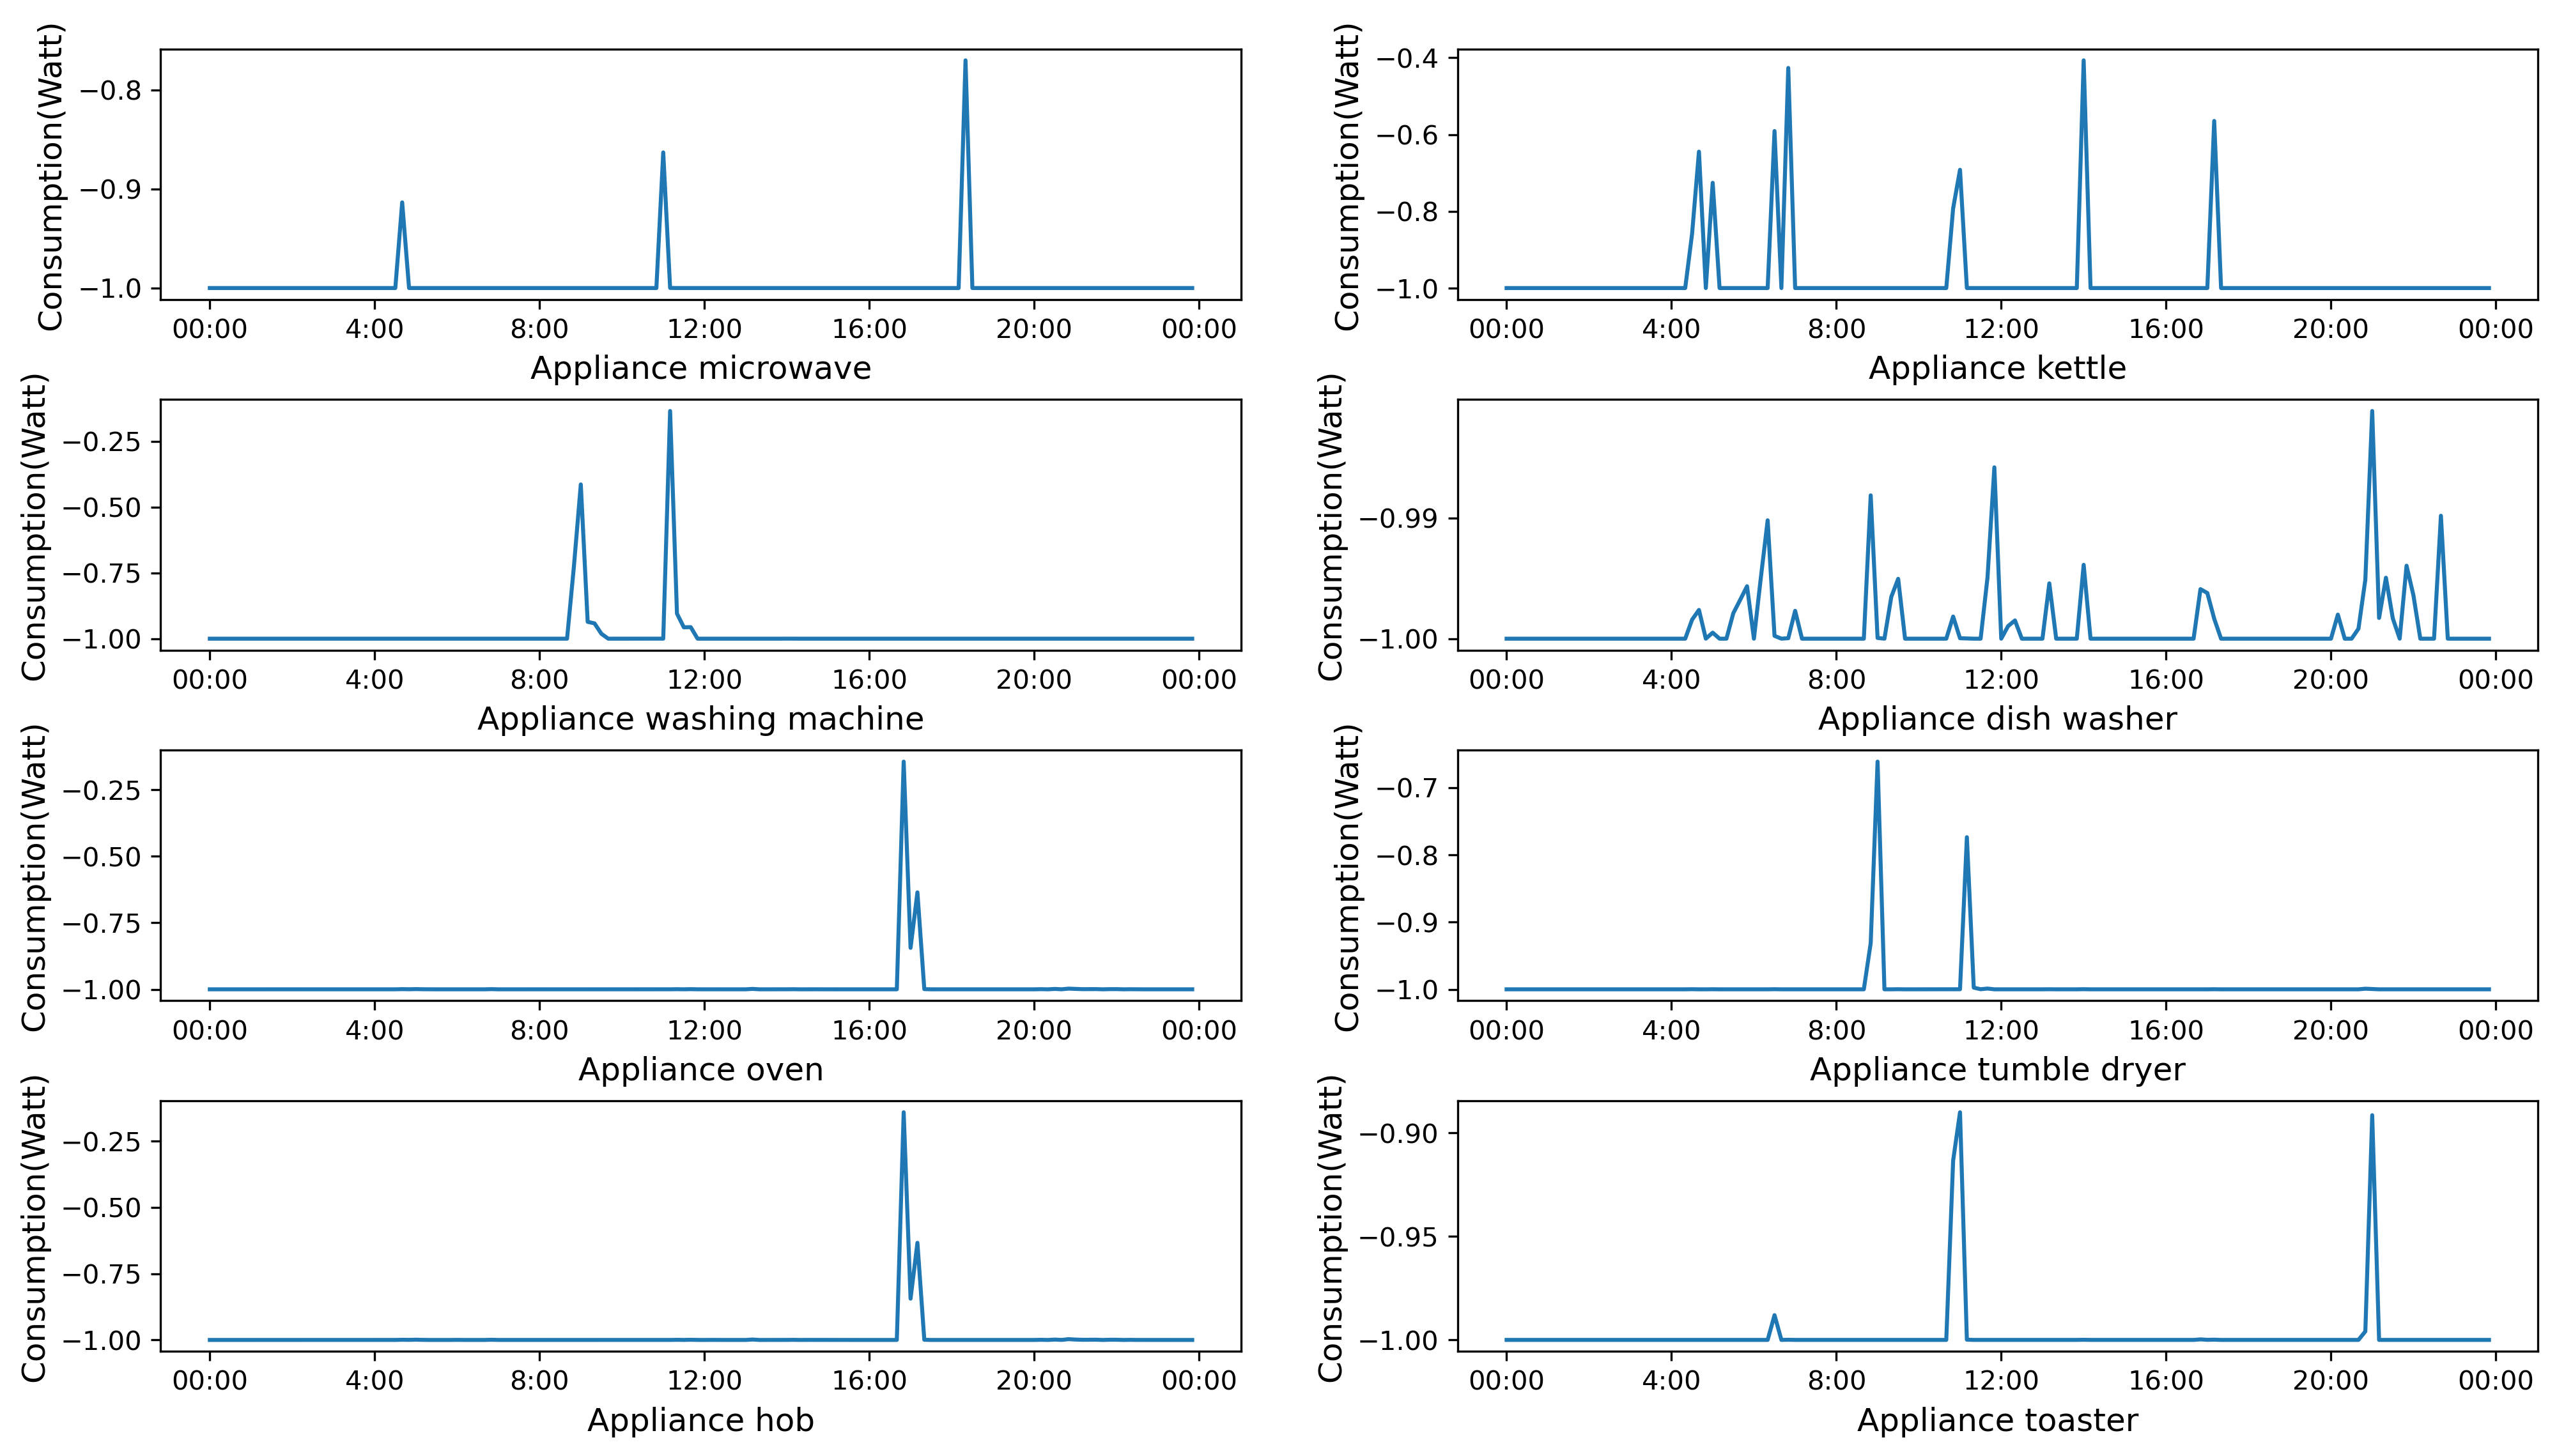

In [24]:
plt.figure(figsize=(16,9), dpi=300)
grid = plt.GridSpec(nrows=4, ncols=2, wspace=0.2, hspace=0.4)
SLOT = 24

for i, app in enumerate(APPS):
    fig = plt.subplot(grid[int(i/2), int(i%2)])
    fig.plot(df_std[app][144*(SLOT):144*(SLOT+1)])
    fig.set_xticks(np.array([0,24,48,72,96,120,144]) +144*(SLOT))
    fig.set_xticklabels(['00:00', '4:00', '8:00', '12:00','16:00', '20:00', '00:00'])
    fig.set_xlabel('Appliance ' + APPS_DICT[app])
    fig.set_ylabel('Consumption(Watt)')

In [15]:
df_std.describe()

,20,9,5,34,35,42,47,48,28,hour_cos,...,day_sin,month_sin,norm_20,norm_9,norm_5,norm_34,norm_35,norm_42,norm_48,norm_28
count,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,...,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000
mean,-0.994198,-0.982568,-0.997241,-0.998598,-0.993533,-0.999077,-0.993451,-0.993491,-0.995509,-1.055642,...,-1.000000,-1.095451,-0.989814,-0.945200,-0.992195,-0.989829,-0.990718,-0.997583,-0.990612,-0.992580
std,0.064277,0.110302,0.047138,0.020668,0.066793,0.017676,0.067404,0.066937,0.055993,1.545458,...,1.511864,1.347007,0.070795,0.156442,0.074566,0.041905,0.065956,0.023789,0.066315,0.047338
min,-1.002343,-1.000000,-1.000000,-1.000009,-1.000008,-1.000000,-1.000021,-1.000003,-1.000267,-3.270057,...,-3.000000,-3.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000061,-1.000000,-1.000085,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.488739,...,-3.000000,-2.527042,-1.000000,-1.000000,-1.000000,-1.000000,-1.000061,-1.000000,-1.000085,-1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.411235,...,1.000000,0.092401,-0.999989,-0.998218,-0.999993,-0.992244,-0.999441,-0.999975,-0.999366,-0.999786
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
df.describe()

,20,9,5,34,35,42,47,48,28,hour_cos,day_cos,month_cos,hour_sin,day_sin,month_sin
count,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,116928.000000,1.169280e+05,1.169280e+05,1.169280e+05
mean,8.948387,10.807898,2.218423,9.459993,13.359340,0.820728,13.522405,13.654070,1.418768,0.041667,0.142857,-0.007047,-4.934157e-17,-2.815364e-17,-4.723989e-02
std,54.537491,67.740096,37.901401,12.648020,123.645112,15.721875,123.286093,123.930300,14.868140,0.720487,0.742311,0.743846,6.922216e-01,6.546565e-01,6.666483e-01
min,2.037653,0.102080,0.000000,8.596221,1.373499,0.000000,1.505871,1.596783,0.155587,-0.990686,-1.000000,-0.959493,-9.976688e-01,-8.660254e-01,-9.898214e-01
25%,4.025425,0.102080,0.000000,8.601741,1.388306,0.000000,1.543996,1.602915,0.226363,-0.626438,-0.500000,-0.654861,-6.560249e-01,-8.660254e-01,-7.557496e-01
50%,4.025425,0.102080,0.000000,8.601741,1.388306,0.000000,1.543996,1.602915,0.226363,0.067607,0.500000,-0.142315,-1.224647e-16,0.000000e+00,-1.133108e-15
75%,4.025425,0.102080,0.000000,8.601741,1.388306,0.000000,1.543996,1.602915,0.226363,0.725520,1.000000,0.841254,6.560249e-01,8.660254e-01,5.406408e-01
max,1700.976563,1228.367092,1608.115292,1232.505274,3703.718791,1778.863614,3659.675487,3704.514267,531.300757,1.000000,1.000000,1.000000,9.976688e-01,8.660254e-01,9.898214e-01


In [27]:
def get_gap_duration(dataframe, label):
    df_len = dataframe.shape[0]
    app_df = dataframe[label]
    threshold = app_df.describe().loc['50%']
    duration_dict = {}
    for app in label:
        app_data = app_df[app]
        th = threshold[app]

        index = app_data.loc[app_data > th]
        duration_dict[app] = {'total_duration':index.shape[0]}
        duration_dict[app]['active_percentage'] = float(index.shape[0]/df_len)
        index = index.index.to_numpy()
        gap = []
        dur = []
        start, end = 0, 1
        for i in range(1, index.shape[0]):
            if index[i]-index[i-1] == 1:
                end += 1
            else:
                gap.append(index[i]-index[i-1])
                dur.append(end-start)
                start = i
                end = i + 1
        duration_dict[app]['max_gap'] = np.array(gap).max()
        duration_dict[app]['avg_gap'] = np.array(gap).mean()
        duration_dict[app]['max_duration'] = np.array(dur).max()
        duration_dict[app]['avg_duration'] = np.array(dur).mean()


    return pd.DataFrame(duration_dict)

In [28]:
# get_gap_duration(df, APPS)

In [31]:
gapdu = get_gap_duration(df_std, ["norm_"+str(x) for x in APPS])
gapdu

norm_20   -1.000011
norm_9    -1.001784
norm_5    -1.000007
norm_34   -1.007787
norm_35   -1.000559
norm_42   -1.000025
norm_48   -1.000634
norm_28   -1.000214
Name: 50%, dtype: float64


,norm_20,norm_9,norm_5,norm_34,norm_35,norm_42,norm_48,norm_28
total_duration,29608.000000,46591.000000,49525.000000,52489.000000,58464.000000,52562.000000,58464.000000,47961.000000
active_percentage,0.253216,0.398459,0.423551,0.448900,0.500000,0.449524,0.500000,0.410175
max_gap,747.000000,2522.000000,1157.000000,1355.000000,477.000000,589.000000,478.000000,2522.000000
avg_gap,45.263538,30.706897,26.165523,26.566329,18.742617,25.969457,17.881988,29.879863
max_duration,63.000000,107.000000,92.000000,121.000000,137.000000,107.000000,116.000000,107.000000
avg_duration,15.263022,20.073276,18.883677,21.285598,18.168791,20.841729,17.287489,20.495938


In [26]:

# from loss_func import SliceMSELoss
from models import *
import tensorflow as tf

MAX_EPOCHS = 999
INPUT_STEPS = 144
OUTPUT_STEPS = 36
LSTM_UNITS = 16
BATCH_SIZE = 64

In [16]:
## build up the datasets

from window_generator_reg import WindowGenerator

fea_app = [20,9,5,34,35,42,48,28]
fea_ori = [20,9,5,34,35,42,48,28,'hour_cos','hour_sin','day_cos','day_sin','month_sin','month_cos']
fea_norm = ['norm_20', 'norm_9','norm_5','norm_34','norm_35','norm_42', 'norm_48','norm_28']
fea_without_time = [20,9,5,34,35,42,48,28,'gap_20','lagu_20','gap_9','lagu_9',
                    'gap_5','lagu_5','gap_34','lagu_34','gap_35','lagu_35','gap_42','lagu_42',
                    'gap_48','lagu_48','gap_28','lagu_28',]
fea_gap_lagu = ['gap_20','lagu_20','gap_9','lagu_9','gap_5','lagu_5','gap_34','lagu_34','gap_35','lagu_35',
                'gap_42','lagu_42', 'gap_48','lagu_48','gap_28','lagu_28',]

FEA = fea_norm

## dataset
win_generator = WindowGenerator(input_width=INPUT_STEPS, label_width=OUTPUT_STEPS, shift=OUTPUT_STEPS, 
                                train_df=df_std, test_df=None, val_df=None,
                                batch_size=BATCH_SIZE, features_columns=FEA, label_columns=FEA)
print(win_generator.train.cardinality().numpy())
test_y = []
## test the datasets
for test_inputs, test_labels in win_generator.train.take(1):
    test_y.append(test_labels)
    print('Inputs Shape', test_inputs.shape)
    print('Labels Shape', test_labels.shape)

609
Inputs Shape (64, 144, 8)
Labels Shape (64, 36, 8)


In [17]:
model_n = NBEATS_LSTM(
        INPUT_STEPS, 
        OUTPUT_STEPS, 
        len(FEA), 
        len(APPS), 
        units=LSTM_UNITS, 
        num_blocks=2, 
        num_slices=6, 
        if_cnn=True, 
        if_att=True, 
        att_type='additive')
model_n.build((BATCH_SIZE, INPUT_STEPS, len(FEA)))
model_n.load_weights('models\\compare\\comp_nbeats_add_lstm.h5')

# model = ML_LSTM_S2S(units=LSTM_UNITS, out_steps=OUTPUT_STEPS, out_dims=len(APPS), if_cnn=True, num_slices=6)
model_a = Att_ML_S2S(
        units=LSTM_UNITS, 
        out_steps=OUTPUT_STEPS, 
        out_dims=len(FEA), 
        attention_type='multihead', 
        num_slices=6, 
        if_cnn=True
        )
model_a.build((BATCH_SIZE, INPUT_STEPS, 8))
# model.load_weights('models\\compare\\comp_cnn_ml_lstm_s2s.h5')
# model.load_weights('history/num_slices/6/att_ml_s2s.h5')
model_a.load_weights('models/multihead_ml.h5')
# model.summary()


In [18]:
# for x,y in win_generator.val.take(1):
#     y_hat, cnn_output, enc_output, dec_output = model.predict(x)

# plt.plot(cnn_output[33, :, 29])
# plt.plot(enc_output[33, :, 29])
# plt.plot(dec_output[33, :, 29])

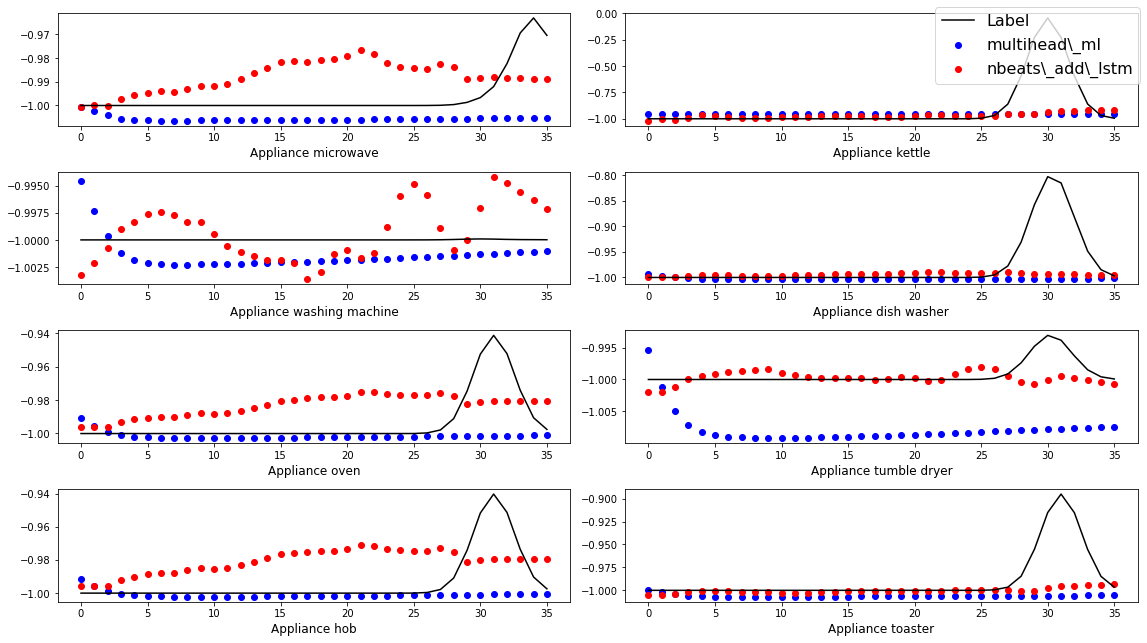

In [19]:
num_test_win = 1
Y,Y_hat_N,Y_hat_A, X = [], [], [],[]
for x,y in win_generator.train.take(1):
    y_hat_n,_,_,_ = model_n(x)
    y_hat_a = model_a(x)
    for i in range(num_test_win):
        Y.append(y[i])
        Y_hat_N.append(y_hat_n[i])
        Y_hat_A.append(y_hat_a[i])
        X.append(x[i])
Y = np.array(Y).reshape(-1,len(APPS))
Y_hat_N = np.array(Y_hat_N).reshape(-1,len(APPS))
Y_hat_A = np.array(Y_hat_A).reshape(-1,len(APPS))
X = np.array(X).reshape(-1,len(APPS))
f = plt.figure(figsize=(16,9))
plt.rc('legend', fontsize=16)
# x_index = np.arange(0, X.shape[0])
# y_index = np.arange(X.shape[0], X.shape[0]+Y.shape[0])
y_index = np.arange(0, Y.shape[0])
for i, app in enumerate([20,9,5,34,35,42,48,28]):
    fig = plt.subplot(4,2,i+1)
    # fig.plot(x_index, X[:,i], c='black', label='Input')
    fig.plot(y_index, Y[:,i], c='black', label='Label')
    fig.scatter(y_index, Y_hat_A[:,i], c='blue', label='multihead\_ml')
    fig.scatter(y_index, Y_hat_N[:,i], c='red', label='nbeats\_add\_lstm')
    fig.set_xlabel('Appliance ' + APPS_DICT[app])
lines, labels = f.axes[-1].get_legend_handles_labels()
plt.tight_layout()
f.legend(lines, labels)
plt.show()


In [20]:
# pd.DataFrame(X[0].numpy()).to_csv('test_x.csv', index=None)
# pd.DataFrame(Y).to_csv('test_y.csv', index=None)

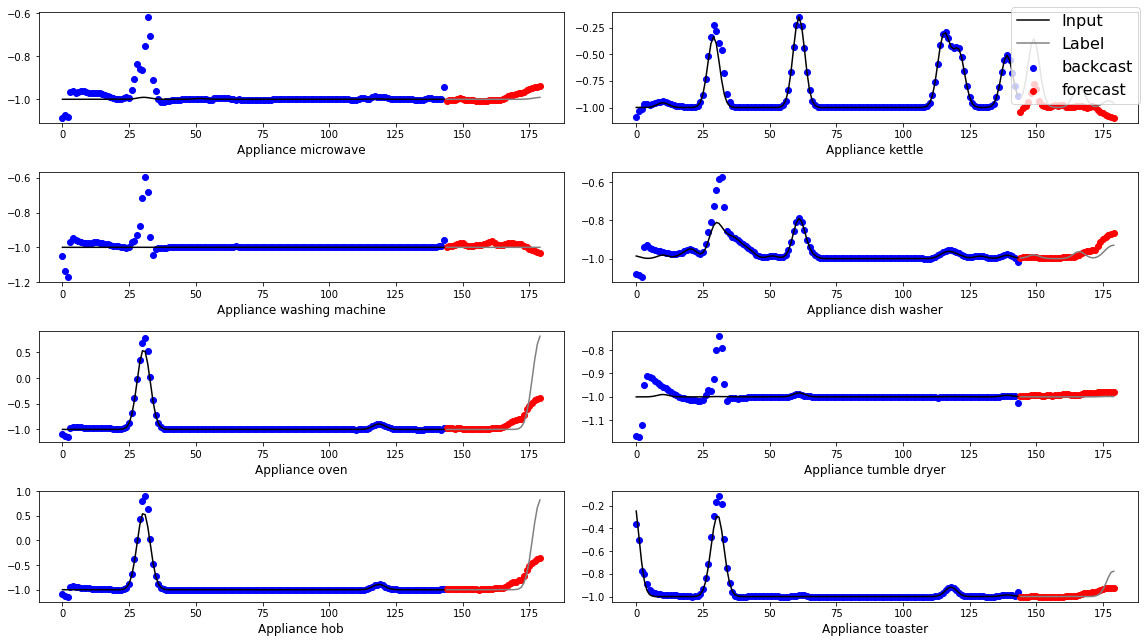

In [21]:
test_x = pd.read_csv('test_x.csv').to_numpy().reshape(1,144,8)
test_y = pd.read_csv('test_y.csv').to_numpy().reshape(1,36,8)
fore, back,_,_ = model_n(test_x, training=False)
x_index = np.arange(0, 144)
y_index = np.arange(144, 144+36)
f = plt.figure(figsize=(16,9))
plt.rc('legend', fontsize=16)
for i, app in enumerate([20,9,5,34,35,42,48,28]):
    fig = plt.subplot(4,2,i+1)
    fig.plot(x_index, test_x[0,:,i], c='black', label='Input')
    fig.plot(y_index, test_y[0,:,i], c='grey', label='Label')
    fig.scatter(x_index, back[0,:,i], c='blue', label='backcast')
    fig.scatter(y_index, fore[0,:,i], c='red', label='forecast')
    fig.set_xlabel('Appliance ' + APPS_DICT[app])
lines, labels = f.axes[-1].get_legend_handles_labels()
plt.tight_layout()
f.legend(lines, labels)
plt.savefig('backcast.png', dpi=200)
plt.show()


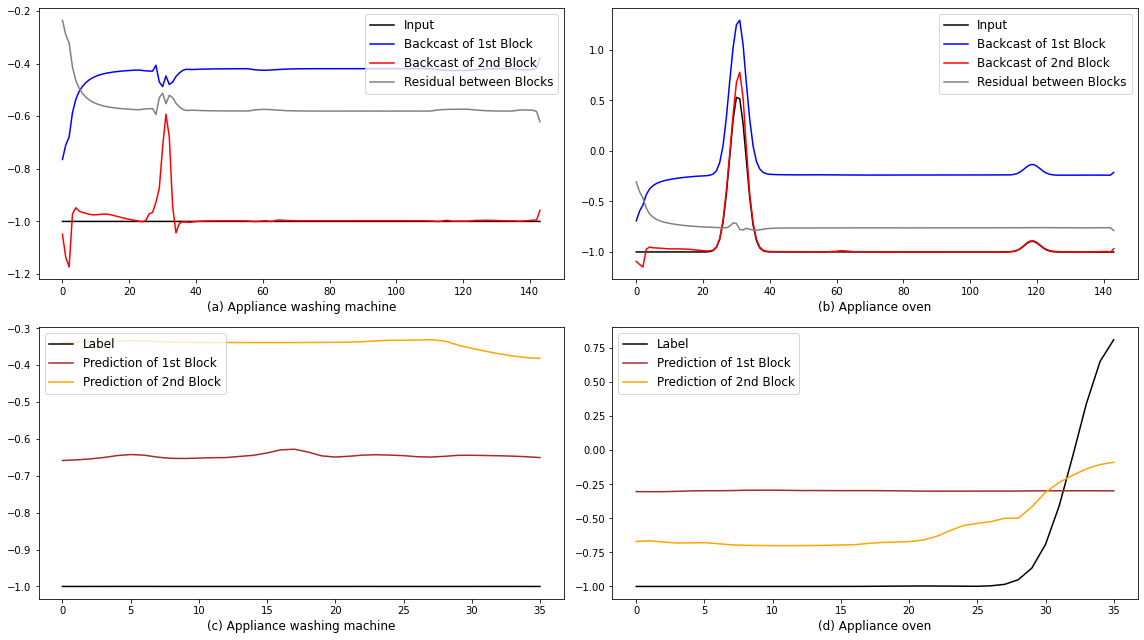

In [25]:
test_x = pd.read_csv('test_x.csv').to_numpy().reshape(1,144,8)
test_y = pd.read_csv('test_y.csv').to_numpy().reshape(1,36,8)
fore, back,res,minifore = model_n(test_x, training=False)
f = plt.figure(figsize=(16,9))
plt.rc('legend', fontsize=12)

fig = plt.subplot(2,2,1)
fig.plot(test_x[0,:,2], c='black', label='Input')
fig.plot(res[0][0,:,2], c='blue', label='Backcast of 1st Block')
fig.plot(res[1][0,:,2], c='red', label='Backcast of 2nd Block')
fig.plot(test_x[0,:,2] - res[0][0,:,2], c='grey', label='Residual between Blocks')
fig.set_xlabel('(a) Appliance washing machine')
fig.legend(loc=1)

fig = plt.subplot(2,2,2)
fig.plot(test_x[0,:,4], c='black', label='Input')
fig.plot(res[0][0,:,4], c='blue', label='Backcast of 1st Block')
fig.plot(res[1][0,:,4], c='red', label='Backcast of 2nd Block')
fig.plot(test_x[0,:,4] - res[0][0,:,4], c='grey', label='Residual between Blocks')
fig.set_xlabel('(b) Appliance oven')
fig.legend(loc=1)

fig = plt.subplot(2,2,3)
fig.plot(test_y[0,:,2], c='black', label='Label')
fig.plot(minifore[0][0,:,2], c='brown', label='Prediction of 1st Block')
fig.plot(minifore[1][0,:,2], c='orange', label='Prediction of 2nd Block')
fig.set_xlabel('(c) Appliance washing machine')
fig.legend(loc=2)

fig = plt.subplot(2,2,4)
fig.plot(test_y[0,:,4], c='black', label='Label')
fig.plot(minifore[0][0,:,4], c='brown', label='Prediction of 1st Block')
fig.plot(minifore[1][0,:,4], c='orange', label='Prediction of 2nd Block')
fig.set_xlabel('(d) Appliance oven')
fig.legend(loc=2)

plt.tight_layout()
plt.savefig('residual.png', dpi=200)
plt.show()


# Plot his

In [188]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter, FixedLocator
import numpy as np
import pandas as pd
import os

filelist = []
namelist = []
for root, dirs, files in os.walk('output/compare/'):
    for file in files:
        if file.startswith('his_'):
            filelist.append(os.path.join(root,file))
            namelist.append(file[4:-4])
        else: 
            continue
plot_list = {
    # 'batchsize=32':pd.read_csv('history/batchsize/32_single_his.csv'),
    # 'batchsize=64':pd.read_csv('history/batchsize/64_single_his.csv'),
    # 'batchsize=96':pd.read_csv('history/batchsize/96_single_his.csv'),
    # 'batchsize=128':pd.read_csv('history/batchsize/128_single_his.csv'),
    # 'batchsize=64':pd.read_csv('history/batchsize/64_nbeats_his.csv'),
    # 'batchsize=128':pd.read_csv('history/batchsize/128_nbeats_his.csv'),
    # 'batchsize=256':pd.read_csv('history/batchsize/256_nbeats_his.csv'),

    # 'LR=1e-6':pd.read_csv('history/lr/1e6_nbeats_his.csv'),
    # 'LR=1e-7':pd.read_csv('history/lr/1e7_nbeats_his.csv'),
    # 'LR=1e-8':pd.read_csv('history/lr/1e8_nbeats_his.csv'),
    # 'LR=1e-4':pd.read_csv('history/lr/1e4_single_his.csv'),
    # 'LR=1e-5':pd.read_csv('history/lr/1e5_single_his.csv'),
    # 'LR=5e-6':pd.read_csv('history/lr/5e6_single_his.csv'),
    # 'LR=2e-6':pd.read_csv('history/lr/2e6_single_his.csv'),
    # 'LR=1e-6':pd.read_csv('history/lr/1e6_single_his.csv'),

    # 'num_slices_9':pd.read_csv('history/num_slices/9/single_his.csv'),
    # 'num_slices_6':pd.read_csv('history/num_slices/6/single_his.csv'),
    # 'num_slices_4':pd.read_csv('history/num_slices/4/single_his.csv'),

    # 'units=4': pd.read_csv('history/units/4_nbeats_his.csv'),
    # 'units=8': pd.read_csv('history/units/8_nbeats_his.csv'),
    # 'units=16': pd.read_csv('history/units/16_nbeats_his.csv'),
    'units=8': pd.read_csv('history/units/units_8_his.csv'),
    'units=12': pd.read_csv('history/units/units_12_his.csv'),
    'units=16': pd.read_csv('history/units/units_16_his.csv'),
    'units=32': pd.read_csv('history/units/units_32_his.csv'),


    # 'Pure MSE': pd.read_csv('history/num_slices/1_single_his.csv'),
    # '3': pd.read_csv('history/num_slices/3_single_his.csv'),
    # '4': pd.read_csv('history/num_slices/4_single_his.csv'),
    # '6': pd.read_csv('history/num_slices/6_single_his.csv'),

    # 'Layers=2': pd.read_csv('history/num_layers/2_single_his.csv'),
    # 'Layers=3': pd.read_csv('history/num_layers/3_single_his.csv'),
    # 'Layers=4': pd.read_csv('history/num_layers/4_single_his.csv'),

}

# for (name, file) in zip(namelist, filelist):
#     plot_list[name] = pd.read_csv(file)


In [189]:
for key,value in plot_list.items():
    print('{} & {:.5f} & {:.5f} & {:.5f} & {:.5f} '.format(key, value['loss'].iloc[-5:].mean(), 
    value['val_loss'].iloc[-5:].mean(), value['mean_absolute_error'].iloc[-5:].mean(), value['val_mean_absolute_error'].iloc[-5:].mean()))

units=8 & 0.00586 & 0.00498 & 0.04311 & 0.03610 
units=12 & 0.00415 & 0.00384 & 0.02412 & 0.01847 
units=16 & 0.00413 & 0.00382 & 0.02404 & 0.01753 
units=32 & 0.00413 & 0.00384 & 0.02391 & 0.01699 


In [184]:
for key,value in plot_list.items():
    print('{} & {:.5f} & {:.5f} & {:.5f} & {:.5f} '.format(key, value['loss'].iloc[49].mean(), 
    value['val_loss'].iloc[49].mean(), value['mean_absolute_error'].iloc[49].mean(), value['val_mean_absolute_error'].iloc[49].mean()))

addictive_ml & 0.10903 & 0.10050 & 0.26464 & 0.25159 
addictive_sl & 0.48780 & 0.46977 & 0.64808 & 0.63986 
cnn_ml_lstm_s2s & 0.29297 & 0.28664 & 0.48144 & 0.47642 
cnn_sl_lstm_s2s & 0.45150 & 0.44451 & 0.61856 & 0.61217 
ml_lstm & 0.52841 & 0.51937 & 0.72215 & 0.71590 
ml_lstm_s2s & 0.60887 & 0.60020 & 0.73100 & 0.72135 
multihead_ml & 0.46677 & 0.45753 & 0.65675 & 0.64877 
multihead_sl & 0.35717 & 0.34031 & 0.55905 & 0.54099 
nbeats & 0.00367 & 0.00335 & 0.08270 & 0.08134 
nbeats_add_lstm & 0.00374 & 0.00341 & 0.02338 & 0.02037 
nbeats_lstm & 0.00384 & 0.00355 & 0.02427 & 0.02326 
nbeats_mh_lstm & 0.00367 & 0.00346 & 0.02323 & 0.01969 
sl_lstm & 0.54556 & 0.53416 & 0.73147 & 0.72356 
sl_lstm_s2s & 0.21476 & 0.20874 & 0.42641 & 0.41881 


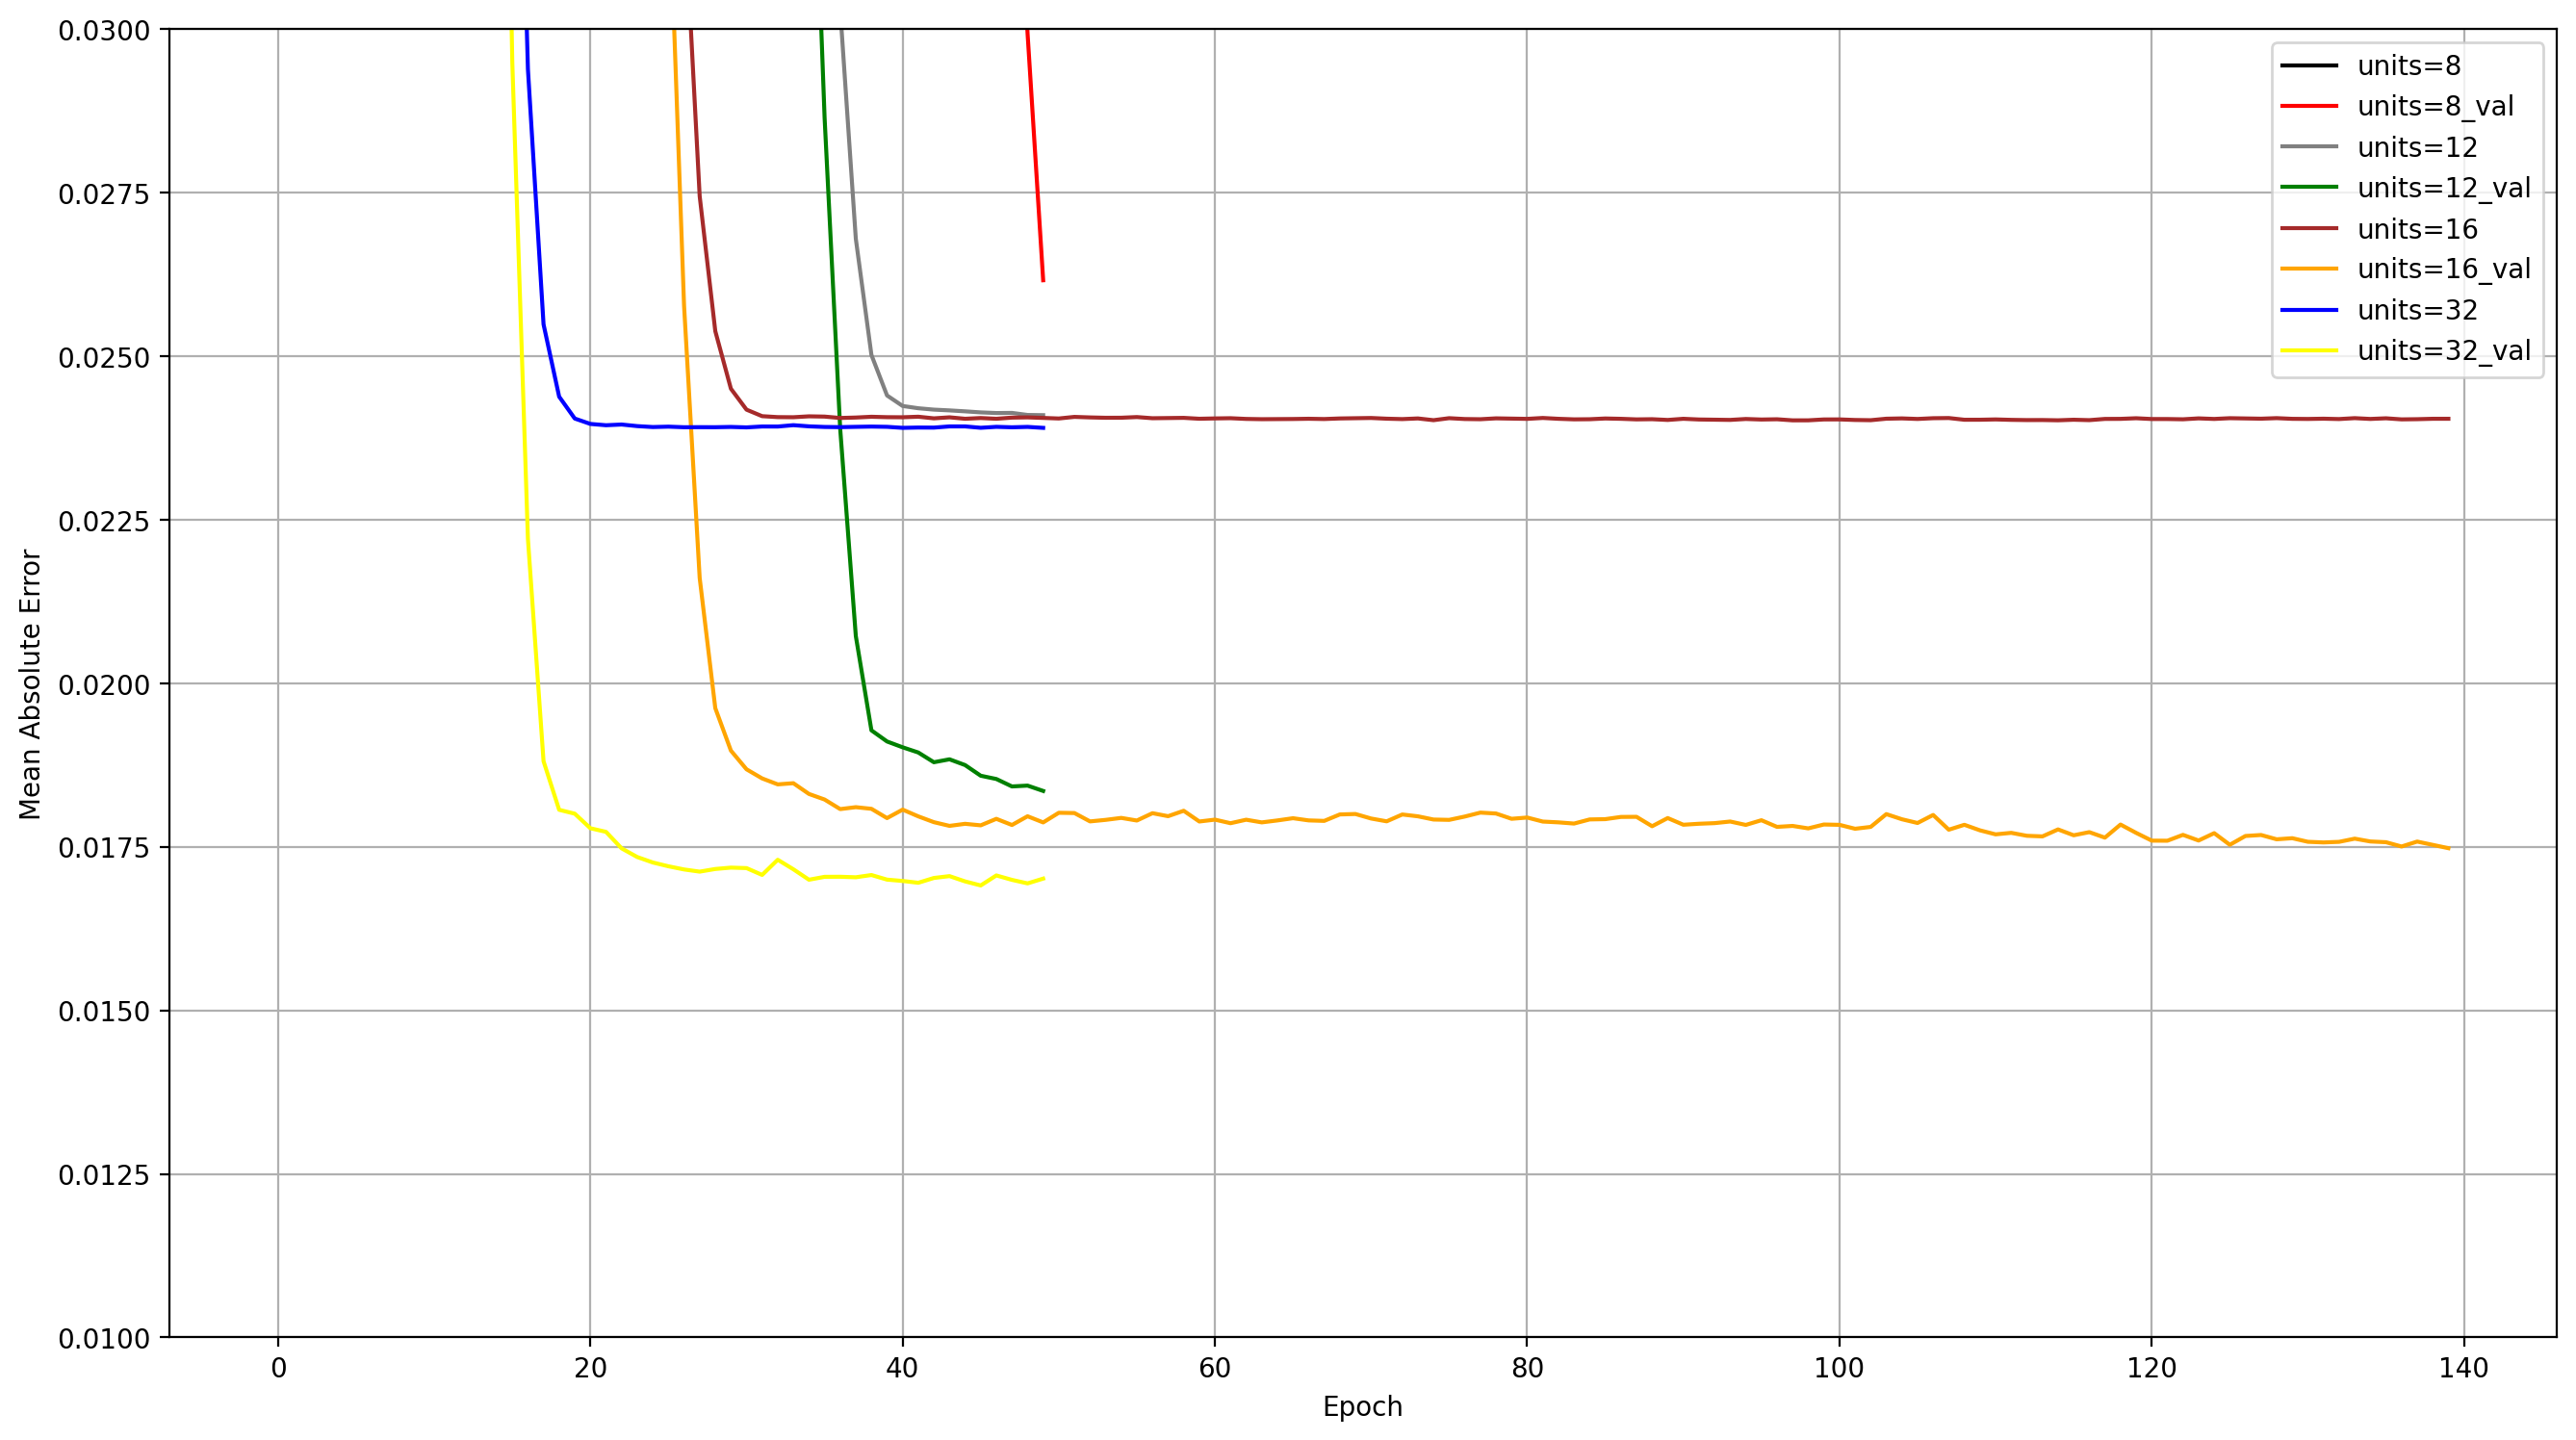

In [190]:
metric='mean_absolute_error'
metric_val='val_mean_absolute_error'
# metric='loss'
# metric_val='val_loss'

dark_c = ['black', 'grey', 'brown', 'blue', 'purple']
light_c = ['red', 'green', 'orange', 'yellow', 'pink']
plt.figure(figsize=(16,9), dpi=200)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
i=0
for key,value in plot_list.items():
    plt.plot(value[metric], label=key, color=dark_c[i])
    plt.plot(value[metric_val], label=key+'_val', color=light_c[i])
    # plt.plot(value[metric], label=key)
    # plt.plot(value[metric_val], label=key+'_val')
    i+=1
# plt.ylim(0.002,0.007)
plt.ylim(0.01,0.03)
plt.grid(True)
plt.legend()

In [185]:
performance = pd.read_csv('output/compare/compare.csv').to_dict()
train_mae, val_mae, train_loss, val_loss, train_mape, val_mape = [], [], [], [], [], []
for item in performance:
    train_mae.append(float(performance[item][0].strip('][').split(', ')[1]))
    val_mae.append(float(performance[item][1].strip('][').split(', ')[1]))
    train_loss.append(float(performance[item][0].strip('][').split(', ')[0]))
    val_loss.append(float(performance[item][1].strip('][').split(', ')[0]))

In [186]:
for i, key in enumerate(performance.keys()):
    print('{} & {:.5f} & {:.5f} & {:.5f} & {:.5f}'.format(key, train_loss[i], val_loss[i], train_mae[i], val_mae[i]))

baseline_1 & 0.00643 & 0.00696 & 0.02231 & 0.02041
baseline_2 & 0.00659 & 0.00675 & 0.02261 & 0.02056
baseline_7 & 0.00671 & 0.00632 & 0.02275 & 0.02081
sl_lstm & 0.01193 & 0.01168 & 0.21232 & 0.21188
ml_lstm & 0.00570 & 0.00534 & 0.22944 & 0.22890
sl_lstm_s2s & 0.00421 & 0.00384 & 0.02693 & 0.02600
ml_lstm_s2s & 0.01397 & 0.01381 & 0.07298 & 0.07232
cnn_sl_lstm_s2s & 0.00529 & 0.00495 & 0.04575 & 0.04494
cnn_ml_lstm_s2s & 0.00419 & 0.00381 & 0.02506 & 0.02414
addictive_sl & 0.01105 & 0.01068 & 0.08011 & 0.07929
addictive_ml & 0.00437 & 0.00397 & 0.02311 & 0.02209
multihead_sl & 0.00433 & 0.00394 & 0.02180 & 0.02087
multihead_ml & 0.00417 & 0.00378 & 0.02045 & 0.01948
nbeats & 0.00358 & 0.00327 & 0.04331 & 0.04225
nbeats_lstm & 0.00364 & 0.00330 & 0.02437 & 0.02334
nbeats_add_lstm & 0.00343 & 0.00327 & 0.02036 & 0.01957
nbeats_mh_lstm & 0.00346 & 0.00322 & 0.02193 & 0.02078
